## Font Project--Prototype Code and EDA ##

This script summarizes a lot of the analysis done for my Insight project. The main goals of the code are the following: 

1. Vectorize each .png file by shoving the files into the VGG16 CNN.
2. Engineer the features by reducing the dimensionality 
3. Perform some EDA by exploring if similar fonts are near each other in our font map
4. Using scarped data from the web, come up with a weighting vector to provide recomendations. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy     
import sklearn
import flask
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import networkx as nx
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import h5py
import logging
import json
import time

import tensorflow as tf
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.losses import cosine_proximity
from keras import optimizers
from keras.preprocessing import image
from keras.models import Model

from annoy import AnnoyIndex
from keras import optimizers
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras.losses import cosine_proximity
from keras.preprocessing import image


#to make fonts from plots look normal
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Calibri'
mpl.rcParams['mathtext.it'] = 'Calibri:italic'
mpl.rcParams['mathtext.bf'] = 'Calibri:bold'

font = {'family' : 'Calibri',
        'weight' : 'normal',
        'size'   : 36}
        #'sans-serif' : 'Arial Unicode MS'}
mpl.rc('font', **font)
plt.rc('font', size=36)          # controls default text sizes

#mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 1.5
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 1.5
mpl.rcParams['axes.linewidth'] = 1.5 #set the value globally
mpl.rcParams['lines.markersize'] = 16
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
#mpl.rcParams['xtick.top'] = False
#mpl.rcParams['ytick.right'] = False

logger = logging.getLogger()
logger.setLevel(logging.INFO)

/home/eric/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Vectorizing Images ##

We need to load the pre-trained VGG 16 neural net. Note that we want to get rid of the last, fully connected classiciation layer. Our output is therefore a compressed, vectorized version of the image. 

The hidden layers in this CNN are mostly about finding local structure in the data--that is, looking at color, texture, shapes, edges, etc. While a lot of that might be overkill for our purposes, at least it's trained! 

In [3]:

def load_headless_pretrained_model():
    """
    Loads the pretrained version of VGG with the last layer cut off
    :return: pre-trained headless VGG16 Keras Model
    """
    pretrained_vgg16 = VGG16(weights='imagenet', include_top=True)
    model = Model(inputs=pretrained_vgg16.input,
                  outputs=pretrained_vgg16.get_layer('fc2').output)
    return model

# set the model
CNNmodel = load_headless_pretrained_model()


In [4]:
def generate_features(image_paths, model):
    """
    Takes in an array of image paths, and a trained model.
    Returns the activations of the last layer for each image
    :param image_paths: array of image paths
    :param model: pre-trained model
    :return: array of last-layer activations, and mapping from array_index to file_path
    """
    start = time.time()
    images = np.zeros(shape=(len(image_paths), 224, 224, 3))
    file_mapping = {i: f for i, f in enumerate(image_paths)}

    # We load all our dataset in memory because it is relatively small
    for i, f in enumerate(image_paths):
        img = image.load_img(f, target_size=(224, 224))
        x_raw = image.img_to_array(img)
        x_expand = np.expand_dims(x_raw, axis=0)
        images[i, :, :, :] = x_expand

    logger.info("%s images loaded" % len(images))
    inputs = preprocess_input(images)
    logger.info("Images preprocessed")
    images_features = model.predict(inputs)
    end = time.time()
    logger.info("Inference done, %s Generation time" % (end - start))
    return images_features, file_mapping

In [5]:
# now point the images to the model and clean up the filenames a little bit. 
fileDir = r'/home/eric/Documents/Insight/WebApp/static/FontFiles'

fileDir2 = '/home/eric/Documents/Insight/Project/FontImage/FontFiles'
os.chdir(fileDir)
imagePathArray = ["{}/{}".format(fileDir, f) for f in os.listdir('.') if f.endswith(".png")]

from operator import getitem
clean_names = [(f,f.replace("-font-", "").replace(".png", "").split("-")[-1]) for f in os.listdir(".")]
clean_names.sort(key=lambda x: x[1])


labels = [(f,f.replace("-font-", "").replace(".png", "").split("-")[-1]) for f in os.listdir(".")]
labels = np.asarray(labels)
# print(labels[:,0])
# print(labels.shape)
condensed_mask = [idx for idx, s in enumerate(labels[:,0]) if "Condensed" in s]
italic_mask = [idx for idx, s in enumerate(labels[:,0]) if "italic" in s]
libre_mask = [idx for idx, s in enumerate(labels[:,0]) if "Libre" in s]
sans_mask = [idx for idx, s in enumerate(labels[:,0]) if "Sans" in s]
serif_mask = [idx for idx, s in enumerate(labels[:,0]) if "Serif" in s]

condensed_array = np.asarray(condensed_mask)
italic_array = np.asarray(italic_mask)
libre_array = np.asarray(libre_mask)
sans_array = np.asarray(sans_mask)
serif_array = np.asarray(serif_mask)



In [6]:
# generate the features!

featureVecs = generate_features(imagePathArray,CNNmodel)

Now that we have our features, let's do a little feature engineering. First, scale the features so that they are normalized. Then, run PCA on the scaled features in order to reduce the dimensionality while capture 90% of the variance

In [8]:
# scale the vectors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
VecNorms = scaler.fit(featureVecs[0])


scaledVecs = scaler.transform(featureVecs[0])

# run PCA on the scaled vectors. 
modelPCA = PCA(0.9)
featureSmall2 = modelPCA.fit_transform(scaledVecs)

In [9]:
# let's run a little side experiemnt to see if we can take the inner product of a random vector with the
# rest of the array and see if we can get out a ranked list of similar vectors....ya know, just as a
# sanity checl

from sklearn.metrics.pairwise import cosine_similarity

test_output = cosine_similarity([featureSmall2[2]],featureSmall2)

# give me the top 5 most similar fonts
rankTest = (-test_output).argsort()[:5][0][1:6]
print(rankTest)


[ 264 1464 1337  917 1490]


Now that this *seems* to sorta work, let's try and visualize our output. 

We are going to use the **t-SNE** algoritm, which is great for projecting a high dimensional space into a low dimensional one. Essentially, what this does is take a Euclidean distance metric in a high dimesional space and map it into the probability $p_{i|j}$ that a high dimensional vector $x_{i}$ would select vector $x_{j}$ as its neighbor. It does this by assuming that the probability a neighbor is picked is proportional to the probability density under a Gaussian centered at $x_{i}$; that is

$p_{i|j} = \frac{\text{exp}(\frac{-|x_{i} - x_{j}|^2} {2 \sigma_{i}^2})}   {\sum_{k \neq i}\text{exp}(\frac{-|x_{i} - x_{k}|^2} {2 \sigma_{i}^2})}   $

We can define a similar probability $q_{i|j}$ for low dimensional vectors $y_{i}$ and $y_{j}$. The goal of this analysis is to define an ideal map beween $p_{i|j}$ and $q_{i|j}$, which the algorithm does by minimizing the Kullback-Leibler (KL) divergence. The KL divergence is defined as:

$\sum_{i} \sum_{j} p_{j|i} \text{log} \frac{p_{j|i}}{q_{j|i}}$

This is the cost function of this neural net algorithm. What's **super** cool about this is its connection to Gibb's entropy--basically, you want to minimize the cross entropy between distributions $q$ and $p$ s.t. they represent the same distributions! 

Super cool stuff. Anywho, let's run it. Train the algorithm 5000 times. The only really sensitive hyperparameter here is the perplexity, which is related to this entropy term. The original paper describing tSNE suggests a perplexity between 5 and 50. 

In [10]:
time_start = time.time()
tsne = TSNE(n_components = 2, verbose = 1, perplexity = 15, n_iter = 5000,learning_rate = 1000)
tsne_results2 = tsne.fit_transform(featureSmall2)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 1884 samples in 0.145s...
[t-SNE] Computed neighbors for 1884 samples in 0.910s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1884
[t-SNE] Computed conditional probabilities for sample 1884 / 1884
[t-SNE] Mean sigma: 0.000183
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.966560
[t-SNE] Error after 3700 iterations: 1.012694
t-SNE done! Time elapsed: 103.68216061592102 seconds


/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


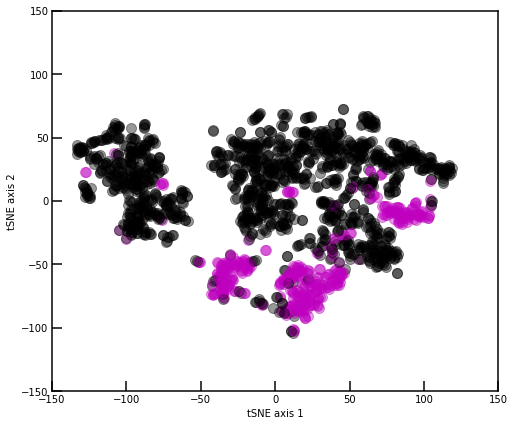

In [11]:
# Make some simple validation plots!

figDirSpec = '/home/eric/Documents/Insight/Project/FontProject/pics/'

# make a black colormap. color any fonts labeled 'italic' purple for validation purposes. Can also color 
# other labeled data
cmap1 = ['k']*len(tsne_results2)

# for index in sans_array:
#     cmap1[index] = 'g'
# for index in condensed_array:
#     cmap1[index] = 'b'
# for index in libre_array:
#     cmap1[index] = 'r'
for index in italic_array:
    cmap1[index] = 'm'
# for index in serif_array:
#     cmap1[index] = 'c'


fig, ax = plt.subplots(1,1, figsize = (8,7))
for ft in range(len(tsne_results2)):
    ax.plot(tsne_results2[ft,0],tsne_results2[ft,1],'o', markersize = 10, c = cmap1[ft], alpha=0.4) 

ax.set_xlabel("tSNE axis 1")
ax.set_ylabel("tSNE axis 2")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([-150,150]);
ax.set_ylim([-150,150]);
# figName = '\\tSNE_serif.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

In addition, make an elbow plot to communicate the results of the PCA and the dimensionality of our space. 

Text(0,0.5,'Explained Variance')

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


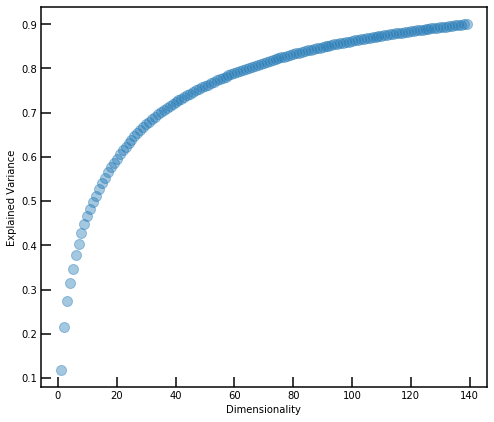

In [12]:
# get number of dimensions used in PCA analysis to capture 90% of variance
PCA_ax = 1+ np.asarray(range(featureSmall2.shape[1]))
PCA_var = np.zeros(len(PCA_ax))
for idx,var in enumerate(modelPCA.explained_variance_ratio_):
#     print(idx)
    PCA_var[idx] = modelPCA.explained_variance_ratio_[idx]
    
PCA_sum = np.cumsum(PCA_var)

fig, ax = plt.subplots(1,1, figsize = (8,7))
ax.plot(PCA_ax[:],PCA_sum[:],'o', markersize = 10, alpha=0.4) 

ax.set_xlabel("Dimensionality")
ax.set_ylabel("Explained Variance")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
# ax.set_xlim([-200,200]);
# ax.set_ylim([-200,200]);
# figName = 'PCA_elbow.png'
# plt.savefig(figDir + figName,dpi = 300,bbox_inches = 'tight')

Now that all this is done, let's try our hand at creating a few different metrics for providing recomendations. 

**Idea 1**: define a contrast similarity metric. A normal inner product sums all of the components of the vector. This means that if the product of an element is negative, it will decrease the inner product, meaning there's less similarity. What if, instead, we take the absolute value of the negative elements and add them? Would that help? Create a balance of 'similar' and 'contrasting' features?

In [13]:
# take a stab at this for single vectors

def cont_met1(fn1,fn2,u):
    '''
    function that determines the contrast metric for generating font recommendations.
    assume fn2 is a large array. the first step is applying the function along each row.
    the parameter u is the weight of the contrasting part. start small--maybe 0.1
    '''
    fboth = fn1*fn2
    
    fpos_pre = fboth.clip(min = 0)
    fneg_pre = fboth.clip(max = 0)
    
    fneg = -u*sum(fneg_pre)
    fpos = sum(fpos_pre)
    
    fpos_sim = fpos/(np.linalg.norm(fn1)*np.linalg.norm(fn2))
    fneg_sim = fneg/(np.linalg.norm(fn1)*np.linalg.norm(fn2))
    
    return (fneg_sim + fpos_sim)

In [14]:
# now that we understand the basic structure, scale it for full arrays

def cont_met(fn1,fn2,u):
    '''
    function that determines the contrast metric for generating font recommendations.
    assume fn2 is a large array. the first step is applying the function along each row.
    the parameter u is the weight of the contrasting part. start small--maybe 0.1
    '''
    # calculate element wise product of the 2 arrays    
    fboth = fn1*fn2
    
    # separate product into negative and positive arrays 
    fpos_pre = fboth.clip(min = 0)
    fneg_pre = fboth.clip(max = 0)
    
    #calculate row-wise sum of the negative and positive arrays
    fneg = -u*np.sum(fneg_pre,axis=1)
    fpos = np.sum(fpos_pre,axis=1)
    
    
    # normalize the test array (# of items = # of rows)
    norm_fn2 = np.linalg.norm(fn2,axis = 1)
    # normalize the test vector
    norm_fn1 = np.linalg.norm(fn1)
    
    fpos_sim = []
    fneg_sim = []
    # for each entry, compute the individual cos(thetas). fpos_sim shows the positive values; fneg_sim holds the negative
    # values
    for norm in range(len(fn2)):
        fpos_sim.append(fpos[norm]/(norm_fn1*norm_fn2[norm]))
        fneg_sim.append(fneg[norm]/(norm_fn1*norm_fn2[norm]))
                  
                  
    fpos_sim = np.asarray(fpos_sim)
    fneg_sim = np.asarray(fneg_sim)
    
    return (fneg_sim + fpos_sim)


In [15]:
cont_TEST = cont_met(featureSmall2[982],featureSmall2,4)
# print(fTEST)

cont_out = cont_met1(featureSmall2[982],featureSmall2[1028],4)
# print(iAmFucked)

cont_sorted = (-cont_TEST).argsort()
min(cont_TEST)

0.63802016

Ok well that works. Before we go any further in testing this, we are going to need to clean up our label names. Let's do that boring bit now and run some larger tests.

In [17]:
fontFamily = [f.replace("+"," ") for f in labels[:,1]]
fontFamily = np.asarray(fontFamily)

searchTerm1 = 'Lora'
idxArray1 = []
idxArray1 = [idx for idx,label in enumerate(fontFamily) if searchTerm1 in label]

idxSubArray1 = labels[idxArray1]
FileSelect1 =[filename for filename in idxSubArray1[:,0] if 'regular' in filename][0]
# print(idxSubArray1)
# print(FileSelect1)
idxSelect1 = [idx for idx,filename in enumerate(labels[:,0]) if FileSelect1 in filename][0]
# print(idxSelect1)

validVec1 = featureSmall2[idxSelect1]

##############################################################

searchTerm2 = 'Merriweather'
idxArray2 = []
idxArray2 = [idx for idx,label in enumerate(fontFamily) if searchTerm2 in label]

idxSubArray2 = labels[idxArray2]
FileSelect2 =[filename for filename in idxSubArray2[:,0] if 'regular' in filename][0]
# print(idxSubArray2)
# print(FileSelect2)
idxSelect2 = [idx for idx,filename in enumerate(labels[:,0]) if FileSelect2 in filename][0]
# print(idxSelect2)

validVec2 = featureSmall2[idxSelect2]

In [19]:
# see if we can perform these annoying string ops....

test = labels[idxArray2][:,0]
# print(test)

test2 = [f.replace("-font-", "").replace(".png","") for f in test]
# print(test2)

for t in test2:
    important = t.split("-")[1:]
    firstelement = important[0][0]
    if len(important[0]) > 3:
        firstel = important[0][0]
        if firstel.isdigit():
            num = important[0][:3]
            rest = important[0][3:]
            result = [num, rest, important[1]]
        else:
            rest = important[0]
            result = [rest, important[1]]

    else:
        num = important[0]
        result = [num, important[1]]
            
    print(t, result)


00009710-300-Merriweather ['300', 'Merriweather']
00028345-800-Merriweather+Sans ['800', 'Merriweather+Sans']
00027845-300italic-Merriweather+Sans ['300', 'italic', 'Merriweather+Sans']
00010110-700-Merriweather ['700', 'Merriweather']
00028145-700-Merriweather+Sans ['700', 'Merriweather+Sans']
00028445-800italic-Merriweather+Sans ['800', 'italic', 'Merriweather+Sans']
00010410-900italic-Merriweather ['900', 'italic', 'Merriweather']
00027745-300-Merriweather+Sans ['300', 'Merriweather+Sans']
00009910-regular-Merriweather ['regular', 'Merriweather']
00010210-700italic-Merriweather ['700', 'italic', 'Merriweather']
00010010-italic-Merriweather ['italic', 'Merriweather']
00028245-700italic-Merriweather+Sans ['700', 'italic', 'Merriweather+Sans']
00009810-300italic-Merriweather ['300', 'italic', 'Merriweather']
00028045-italic-Merriweather+Sans ['italic', 'Merriweather+Sans']
00010310-900-Merriweather ['900', 'Merriweather']
00027945-regular-Merriweather+Sans ['regular', 'Merriweather+San

That took **way** too long to figure out...

Let's try to apply this to our entire data set and see what happens.

In [21]:
fullArray = labels[:,0]
# print(test)
# print(fullArray)

subArray = [f.replace("-font-", "").replace(".png","") for f in fullArray]

# print(subArray)

sepNames = []
for i,t in enumerate(subArray):
    important = t.split("-")[1:]
    firstelement = important[0][0]
    if len(important[0]) > 3:
        firstel = important[0][0]
        if firstel.isdigit():
            num = important[0][:3]
            rest = important[0][3:]
            result = [num, rest, important[1]]
        else:
            rest = important[0]
            result = [rest, important[1]]

    else:
        num = important[0]
        result = [num, important[1]]
            
    sepNames.append(result)
    
print(len(sepNames))

fullName = []

for n in sepNames:
    fullName.append("-".join(n))
    
# print(fullName)

fullName = [n.replace("-", " ").replace("+", " ") for n in fullName]

# print(fullName)

staticDir = r'/home/eric/Documents/Insight/WebApp/static'
os.chdir(staticDir)



1884


Got it! 

Let's outline what we want our basic function to look like. For now, use the cosine similiarity inner product. We can later port in custom metrics easily. 

In [24]:
def model_output1(user_select,NameVec,featureVec,tSNE_vecs,imagePathList):

    # extract idx of user font
    userIdx = [idx for idx,s in enumerate(NameVec) if user_select in s]
    userIdx = np.asarray(userIdx)

    #perform cosine similarity and obtain rankings and scores 
    simFonts = cosine_similarity(featureVec[userIdx],featureVec)[0]
    recResults = (-simFonts).argsort()[10:15]
    # print(recResults)
    scoreResults = simFonts[recResults]
    # print(scoreResults)

    # make tSNE figure
    figDir = '/home/eric/Documents/Insight/WebApp/static/'

    fig, ax = plt.subplots(1,1, figsize = (8,7))
    for ft in range(len(tsne_results2)):
        ax.plot(tSNE_vecs[ft,0],tSNE_vecs[ft,1],'o', markersize = 10, c = 'k', alpha = 0.1)

    ax.plot(tSNE_vecs[userIdx[0],0],tSNE_vecs[userIdx[0],1],'o', markersize = 20, c = 'r')
    ax.plot(tSNE_vecs[recResults,0],tSNE_vecs[recResults,1],'o', markersize = 10, c = 'b', alpha = 0.9)

    ax.set_xlabel("tSNE axis 1")
    ax.set_ylabel("tSNE axis 2")
    # ax.set_xscale("log") 
    # ax.set_yscale("log") 
    # ax.set_title("|Z| vs. $\omega$")
    ax.set_xlim([-150,150]);
    ax.set_ylim([-150,150]);
#     figName = 'tSNE_figResult.png'
#     plt.savefig(figDir + figName,dpi = 300)
    figName = 'tSNE_figResult'
    test_path = figDir + figName + '_' + np.array2string(userIdx[0]) + '.png'


    # return font names
    fullName2 = np.asarray(NameVec)
    nameResult = fullName2[recResults]
    # print(nameResult)

    # find the font images
    imagePathArray2 = np.asarray(imagePathList)
    imgPaths = imagePathArray2[recResults]
    
    
    # convert the outputs to a list
    nameList = nameResult.tolist()
    scoreList = scoreResults.tolist()
    imgList = imgPaths.tolist()
    
    #also grab user input path
    inputPath = imagePathArray2[userIdx[0]]
    
    return(nameList, scoreList, imgList, inputPath, test_path)


Test line by line first to see if this works. 

/home/eric/Documents/Insight/WebApp/static/tSNE_figResult_1777.png


/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


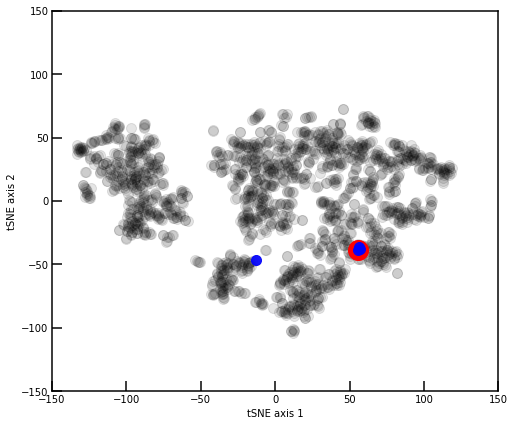

In [23]:
# test font
user_select = 'regular Ceviche One'

# extract idx of user font
userIdx = [idx for idx,s in enumerate(fullName) if user_select in s]
userIdx = np.asarray(userIdx)

#perform cosine similarity and obtain rankings and scores 
simFonts = cosine_similarity(featureSmall2[userIdx],featureSmall2)[0]
recResults = (-simFonts).argsort()[0:4]
# print(recResults)
scoreResults = simFonts[recResults]
# print(scoreResults)

# make tSNE figure
figDir = '/home/eric/Documents/Insight/WebApp/static/'

fig, ax = plt.subplots(1,1, figsize = (8,7))
for ft in range(len(tsne_results2)):
    ax.plot(tsne_results2[ft,0],tsne_results2[ft,1],'o', markersize = 10, c = 'k', alpha = 0.1)

ax.plot(tsne_results2[userIdx[0],0],tsne_results2[userIdx[0],1],'o', markersize = 20, c = 'r')
ax.plot(tsne_results2[recResults,0],tsne_results2[recResults,1],'o', markersize = 10, c = 'b', alpha = 0.9)

ax.set_xlabel("tSNE axis 1")
ax.set_ylabel("tSNE axis 2")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([-150,150]);
ax.set_ylim([-150,150]);
figName = 'tSNE_figResult'
print(figDir + figName + '_' + np.array2string(userIdx[0]) + '.png')


# return font names
fullName2 = np.asarray(fullName)
nameResult = fullName2[recResults]
# print(nameResult)

# find the font images
imagePathArray2 = np.asarray(imagePathArray)
imgPaths = imagePathArray2[recResults]

# convert the outputs to a list
nameList = nameResult.tolist()
scoreList = scoreResults.tolist()
imgList = imagePathArray2.tolist()



## Validation Set--Scraping User Preferences from the Web ##

Alright we have the bones of our pipeline set up. Now, how do we provide recomendations?


Our recomendation engine needs to learn user preferences. We can implement this in a number of ways (multi-armed bandit, anyone...?), but maybe the simplest option is to look at font pairings that use the google font library provided on designer websites.

Luckily, we've scraped that information! It's provided in fontPairs.csv. The idea here is to look at the element-wise difference between font pairings. There is some distribution in the differences of each component. Can we look at what that distribution is, and design a weighting vector? 

In [25]:
os.chdir(r'/home/eric/Documents/Insight/Project/FontProject/presentation_figs')
Vdf = pd.read_csv('fontPairs.csv')
# print(Vdf)

In [26]:
# define a function that will allow us to find the font families mentioned in fontPairs.csv and obtain their
# feature vectors

def validScore2(in1,in2,FontFamArray,LabelArray,featureArray):
    '''
    This function calculates the similiarty metric between fonts listed in the validation set we scraped
    from the web.
    '''
    # input search terms (will be grabbed in a big loop over all rows in pandas DF)
    searchTerm1 = in1
    searchTerm2 = in2
    
    #perform the first searches for each search term
    idxArray1 = []
    idxArray1 = [idx for idx,label in enumerate(FontFamArray) if searchTerm1 in label]
    idxSubArray1 = labels[idxArray1]
    
    idxArray2 = []
    idxArray2 = [idx for idx,label in enumerate(FontFamArray) if searchTerm2 in label]
    idxSubArray2 = labels[idxArray2]
    
    #find the filename and the global index of the font family name     
    FileSelect1 =[filename for filename in idxSubArray1[:,0] if 'regular' in filename][0]
    FileSelect2 =[filename for filename in idxSubArray2[:,0] if 'regular' in filename][0]
    idxSelect1 = [idx for idx,filename in enumerate(LabelArray[:,0]) if FileSelect1 in filename][0]
    idxSelect2 = [idx for idx,filename in enumerate(LabelArray[:,0]) if FileSelect2 in filename][0]
    
    #find the right feature vectors
    validVec1 = featureArray[idxSelect1]
    validVec2 = featureArray[idxSelect2]
    
    return cosine_similarity([validVec1],[validVec2])[0][0]

In [28]:
# calculate cosine similarity and place into a pandas DF

output2 = []
for index, row in Vdf.iterrows():
    try:
        output2.append(validScore2(row['font1'].strip(), row[' font2'].strip(), fontFamily, labels, featureSmall2))
    except:
        output2.append(np.nan)
        
Vdf['cos_score'] = output2


cleanDF = Vdf[~Vdf.cos_score.isna()]
cleanDF.cos_score = cleanDF.cos_score.round(2)

cleanDF2 = cleanDF[cleanDF.cos_score != 1]

# cleanDF2

/home/eric/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [29]:
#### define a function that will allow us to obtain the differences between each component of the font vector
def diffVecs(fontA,fontB,FontFamArray,LabelArray,featureArray):
    '''
    This function takes in the font vector specified in the reference/training data, finds the important
    feature vectors, and outputs the vector differences. 
    '''
    
    # input search terms (will be grabbed in a big loop over all rows in pandas DF)
    searchTerm1 = fontA
    searchTerm2 = fontB
    
    #perform the first searches for each search term
    idxArray1 = []
    idxArray1 = [idx for idx,label in enumerate(FontFamArray) if searchTerm1 in label]
    idxSubArray1 = labels[idxArray1]
    
    idxArray2 = []
    idxArray2 = [idx for idx,label in enumerate(FontFamArray) if searchTerm2 in label]
    idxSubArray2 = labels[idxArray2]
    
    #find the filename and the global index of the font family name     
    FileSelect1 =[filename for filename in idxSubArray1[:,0] if 'regular' in filename][0]
    FileSelect2 =[filename for filename in idxSubArray2[:,0] if 'regular' in filename][0]
    idxSelect1 = [idx for idx,filename in enumerate(LabelArray[:,0]) if FileSelect1 in filename][0]
    idxSelect2 = [idx for idx,filename in enumerate(LabelArray[:,0]) if FileSelect2 in filename][0]
    
    #find the right feature vectors
    validVec1 = featureArray[idxSelect1]
    validVec2 = featureArray[idxSelect2]

    return np.abs(validVec1 - validVec2)


In [30]:
diff_list = []
for index, row in cleanDF2.iterrows():
    try:
        diff_list.append(diffVecs(row['font1'].strip(), row[' font2'].strip(), fontFamily, labels, featureSmall2))
    except:
        diff_list.append(np.nan)

Alright, now we have the differences. In order to make sure we're not just getting garbage, let's normalize each component of mean differences array by the explained variance in the PCA. 

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


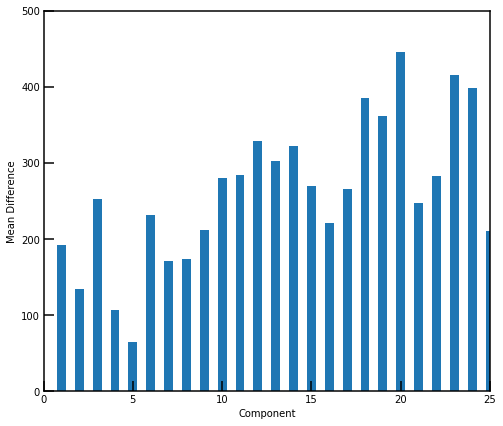

In [32]:
validation_array = np.array([ i for i in diff_list]) 
validation_data = np.mean(np.array([ i for i in diff_list]), axis = 0 )
valid_norm = validation_data/PCA_var

valid_ax = 1 + np.asarray(range(validation_data.shape[0]))

fig, ax = plt.subplots(1,1, figsize = (8,7))
# ax.plot(valid_ax[:],validation_data[:],'o', markersize = 10, alpha=0.4) 
width = 0.5
# ax.bar(x = valid_ax,y = validation_data)
ax.bar(valid_ax, valid_norm, width)


# plot the first few differences
ax.set_xlabel("Component")
ax.set_ylabel("Mean Difference")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([0,25]);
ax.set_ylim([0,500]);
# figName = 'validation_subset.png'
# plt.savefig(figDirSpec + figName,dpi = 300,bbox_inches = 'tight')


# plot.bar(x=days, y=impressions)


We can use this as our weighting array. Use the inverse of the validation data and a weighting factor (say, 50%) to make the weighting array

In [33]:
weight_array = (1/valid_norm)*0.5


Define our unique, **weighted** cosine similarity metric. 

In [34]:
def weighted_cosine_metric(fn1,fn2,weights):
    '''
    function that determines the contrast metric for generating font recommendations.
    assume fn2 is a large array. the first step is applying the function along each row.
    the parameter u is the weight of the contrasting part. start small--maybe 0.1
    '''
    # calculate element wise product of the 2 arrays    
    f_tot = fn1*fn2*weights
    
    #calculate row-wise sum of the negative and positive arrays
    f_sum = np.sum(f_tot,axis=1)
    
    # normalize the font array (# of items = # of rows)
    norm_fn2 = np.linalg.norm(fn2,axis = 1)
    # normalize the input font vector
    norm_fn1 = np.linalg.norm(fn1)
    
    calc_sim = []
    # for each entry, compute the weighted similarity. 
    for norm in range(len(fn2)):
        calc_sim.append(f_sum[norm]/(norm_fn1*norm_fn2[norm]))
                  
                  
    calc_sim_array = np.asarray(calc_sim)
    
    return (calc_sim_array)



def weighted_cosine_metric_small(fn1,fn2,weights):
    '''
    function that determines the contrast metric for generating font recommendations.
    fn2 is a vector. the first step is applying the function along each row.
    the parameter u is the weight of the contrasting part. start small--maybe 0.1
    '''
    # calculate element wise product of the 2 arrays    
    f_tot = fn1*fn2*weights
    
    #calculate row-wise sum of the negative and positive arrays
    f_sum = np.sum(f_tot)
    
    # normalize the font array (# of items = # of rows)
    norm_fn2 = np.linalg.norm(fn2)
    # normalize the input font vector
    norm_fn1 = np.linalg.norm(fn1)
    
    calc_sim = f_sum/(norm_fn1*norm_fn2)
    
    return calc_sim


Update the model

In [35]:
def model_output(user_select,NameVec,featureDimRed,tSNE_vecs,imagePathList,weights):

    # extract idx of user font
    userIdx = [idx for idx,s in enumerate(NameVec) if user_select in s]
    userIdx = np.asarray(userIdx[0])

    #perform cosine similarity and obtain rankings and scores
    simFonts = weighted_cosine_metric(featureDimRed[userIdx],featureDimRed, weights)
    
    recResults = (-simFonts).argsort()[2:6]
    # print(recResults)
    scoreResults = simFonts[recResults]
    # print(scoreResults)

    # make tSNE figure
    fig, ax = plt.subplots(1,1, figsize = (8,7))
    for ft in range(len(tSNE_vecs)):
        ax.plot(tSNE_vecs[ft,0],tSNE_vecs[ft,1],'o', markersize = 10, c = 'k', alpha = 0.1)

    ax.plot(tSNE_vecs[userIdx,0],tSNE_vecs[userIdx,1],'o', markersize = 20, c = 'r')
    ax.plot(tSNE_vecs[recResults,0],tSNE_vecs[recResults,1],'o', markersize = 10, c = 'b', alpha = 0.9)

    ax.set_xlabel("tSNE axis 1")
    ax.set_ylabel("tSNE axis 2")
    # ax.set_xscale("log")
    # ax.set_yscale("log")
    # ax.set_title("|Z| vs. $\omega$")
    ax.set_xlim([-150,150]);
    ax.set_ylim([-150,150]);
#     figDir = '/home/eric/Documents/Insight/WebApp/static/'
#     figName = 'tSNE_figResult.png'
#     plt.savefig(figDir + figName,dpi = 300, bbox_inches = 'tight')


    # return font names
    fullName2 = np.asarray(NameVec)
    nameResult = fullName2[recResults]
    # print(nameResult)

    # find the font images
    imagePathArray2 = np.asarray(imagePathList)
    imgPaths = imagePathArray2[recResults]


    # convert the outputs to a list
    nameList = nameResult.tolist()
    scoreList = scoreResults.tolist()
    imgList = imgPaths.tolist()
    imgList2 =  [path[42:] for path in imgPaths]

    #also grab user input path
    inputPath = imagePathArray2[userIdx]
    inputPath2 =  inputPath[42:]

    return(nameList, scoreList, imgList2, inputPath2)


Let's test our new model!!

(['700 Domine', '800 Martel', '600 Halant', 'regular Pridi'],
 [0.0022431890415169457,
  0.0022415568175102986,
  0.002229494858130979,
  0.0022188443539301983],
 ['/FontFiles/000581-font-115-700-Domine.png',
  '/FontFiles/000731-font-176-800-Martel.png',
  '/FontFiles/001051-font-310-600-Halant.png',
  '/FontFiles/001336-font-446-regular-Pridi.png'],
 '/FontFiles/000522-font-97-700-Noticia+Text.png')

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


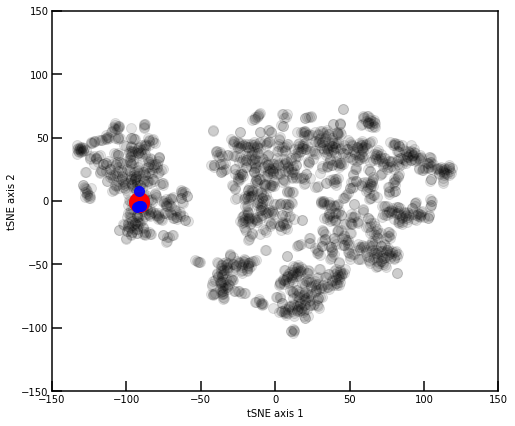

In [36]:
model_output('700 Noticia Text',fullName,featureSmall2,tsne_results2,imagePathArray,weight_array)

(['700 Kalam',
  'regular Permanent Marker',
  '700 Oleo Script',
  'regular Devonshire'],
 [0.001233337225493486,
  0.0012326377017921333,
  0.0011446984921249543,
  0.0011417948715534971],
 ['/FontFiles/000626-font-133-700-Kalam.png',
  '/FontFiles/000598-font-121-regular-Permanent+Marker.png',
  '/FontFiles/000641-font-141-700-Oleo+Script.png',
  '/FontFiles/001805-font-740-regular-Devonshire.png'],
 '/FontFiles/000917-font-245-regular-Ceviche+One.png')

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


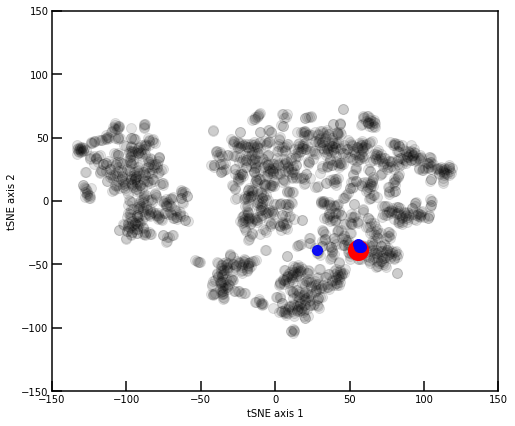

In [37]:
model_output('regular Ceviche One',fullName,featureSmall2,tsne_results2,imagePathArray,weight_array)

In [85]:
import pickle

staticDir = r'/home/eric/Documents/Insight/WebApp/static'
os.chdir(staticDir)

# # # STORE THE tSNE LIST
# with open('tsne_results2.pickle','wb') as file:
#     pickle.dump(tsne_results2, file)

# # # save imagePathArray
# with open('imagePathArray.pickle','wb') as file:
#     pickle.dump(imagePathArray, file)

# # # save font family array
# with open('fontFamily.pickle','wb') as file:
#     pickle.dump(fontFamily, file)

# # #  save label array
# with open('labels.pickle', 'wb') as file:
#     pickle.dump(labels,file)

# # # save feature vector    
# with open('featureVecsFull.pickle','wb') as file:
#     pickle.dump(featureVecs, file)
    
# with open('featureDimRed.pickle','wb') as file:
#     pickle.dump(featureSmall2, file)
    
# # save the weighting array
with open('weight_array.pickle', 'wb') as file:
        pickle.dump(weight_array, file)
        
# # # STORE THE FULL NAME LIST
# with open('fullNames.pickle','wb') as file:
#     pickle.dump(fullName, file)
    

We need to do 1 more thing. Find a mention of, say, Lora and Italic Lora. Find the differences of the two vectors and plot them OR find the nearest match

In [108]:
# Example for presentation
name1 = 'regular Lora'
name2 = 'italic Lora'

userIdx1 = [idx for idx,s in enumerate(fullName) if name1 in s]
userIdx2 = [idx for idx,s in enumerate(fullName) if name2 in s]

# grab user idx and vector arrays. 
userIdx1 = userIdx1[0]
userIdx2 = userIdx2[0]

feature_array1 = featureSmall2[userIdx1]
feature_array2 = featureSmall2[userIdx2]

italic_vec = feature_array2-feature_array1

italic_matches = cosine_similarity([italic_vec],featureSmall2)

italic_match1 = (-italic_matches).argsort()[:5]
italic_match1

# blah = (-test_output).argsort()[:5][0][1:6]
# print(blah)

# test_output = cosine_similarity([featureSmall2[2]],featureSmall2)



array([[ 314, 1782,    8, ...,  441, 1327, 1526]])

/home/eric/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Calibri'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


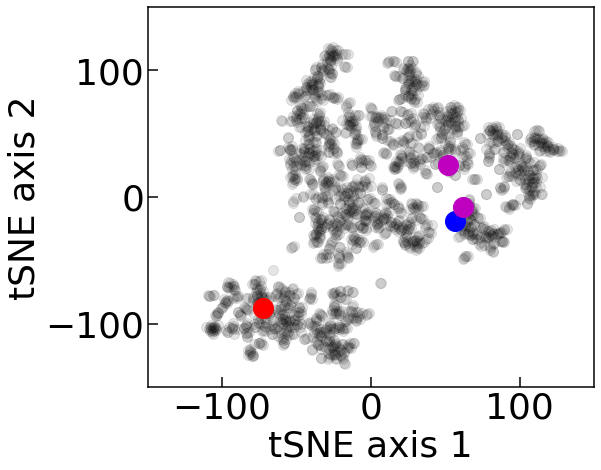

In [120]:
# make example plot for vector operations

fig, ax = plt.subplots(1,1, figsize = (8,7))
for ft in range(len(tsne_results2)):
    ax.plot(tsne_results2[ft,0],tsne_results2[ft,1],'o', markersize = 10, c = 'k', alpha = 0.1)

ax.plot(tsne_results2[userIdx1,0],tsne_results2[userIdx1,1],'o', markersize = 20, c = 'r')
ax.plot(tsne_results2[userIdx2,0],tsne_results2[userIdx2,1],'o', markersize = 20, c = 'b')


ax.plot(tsne_results2[314,0],tsne_results2[314,1],'o', markersize = 20, c = 'm')
ax.plot(tsne_results2[1782,0],tsne_results2[1782,1],'o', markersize = 20, c = 'm')

ax.set_xlabel("tSNE axis 1")
ax.set_ylabel("tSNE axis 2")
# ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("|Z| vs. $\omega$")
ax.set_xlim([-150,150]);
ax.set_ylim([-150,150]);
figName = 'tSNE_vec_op_plot'
plt.savefig(figDirSpec + figName,dpi = 300,bbox_inches = 'tight')
# print(figDir + figName + '.png')

....and we're done!

We've succesfully defined a new metric for our model (the original contrast idea didn't work very well--analysis not shown here...). 
